# Create Pivot Tables

Create a pivot table of patients and conditions. Then combine all individuals and their variants into a single table for analysis.

In [83]:
import pandas as pd
import sqlalchemy as sa
from openpyxl.cell import Cell

In [84]:
# read db connection from .env file
from helpers.settings import get_settings

settings = get_settings()

In [85]:
engine = sa.create_engine(settings.postgresql_dsn.__str__())

In [86]:
df = pd.read_sql(
    """
SELECT i.individual_id, c.condition, ic.has_condition
FROM individual i
JOIN individual_condition ic
ON i.individual_id = ic.individual_id
JOIN condition c
ON ic.condition_id = c.condition_id
""",
    engine,
)
df.head()

,individual_id,condition,has_condition
0,1,Heart Structure Abnormality,False
1,1,Baseline/resting electrocardiogram abnormality,False
2,1,Polymorphic ventricular tachycardia,True
3,1,Exercise/stress induced polymorphic ventricula...,True
4,2,Heart Structure Abnormality,False


In [87]:
df2 = df.copy()
df2 = df2.pivot(index="individual_id", columns="condition",
                values="has_condition")
df2.reset_index(inplace=True)

df2.head()

condition,individual_id,Adult-onset primary generalised epilepsy,Arrhythmia at rest,Arrhythmogenic right ventricular cardiomyopathy,Arteriovenous malformation,Ascending aortic aneurysm,Atrial fibrillation,Atrial flutter,Atrial standstill,Atrial tachycardia,...,Sudden cardiac death,Sudden infant death syndrome,Supraventricular tachycardia,Syncope,Syncope exercise/stress induced,Third-degree atrioventricular block,Unspecified premature ventricular contractions,Ventricular fibrillation,Ventricular tachycardia (unspecified),Weight loss
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,False,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,...,NaN,NaN,NaN,True,True,NaN,False,NaN,NaN,NaN
3,4,NaN,False,NaN,NaN,NaN,False,NaN,NaN,True,...,NaN,NaN,NaN,False,NaN,NaN,False,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# find the current working directory
import os
import IPython

notebook_path = IPython.get_ipython().getoutput('pwd')[0]

data_dir = os.path.join(notebook_path, '..', 'data')

if not os.path.exists(data_dir):
    print(f'Creating directory: {data_dir}')
    os.makedirs(data_dir)

In [89]:
# save to csv
df_file = os.path.join(data_dir, "individual_conditions.csv")
df2.to_csv(df_file, index=False)

# Combine purified data with rest of condition data

In [90]:
df_all_condition = pd.read_sql(
    """
SELECT i.individual_id, c.condition, ic.age_of_onset, ic.description, ic.onset_symptoms, ic.age_of_presentation
FROM individual i
LEFT JOIN individual_condition ic
ON i.individual_id = ic.individual_id
LEFT JOIN condition c
ON ic.condition_id = c.condition_id
""",
    engine,
)
df_all_condition.head()

,individual_id,condition,age_of_onset,description,onset_symptoms,age_of_presentation
0,1,Heart Structure Abnormality,NaN,None,None,NaN
1,1,Baseline/resting electrocardiogram abnormality,NaN,None,None,NaN
2,1,Polymorphic ventricular tachycardia,NaN,None,None,NaN
3,1,Exercise/stress induced polymorphic ventricula...,NaN,None,None,NaN
4,2,Heart Structure Abnormality,NaN,None,None,NaN


In [91]:
df_all_condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13687 entries, 0 to 13686
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   individual_id        13687 non-null  int64  
 1   condition            13687 non-null  object 
 2   age_of_onset         411 non-null    float64
 3   description          260 non-null    object 
 4   onset_symptoms       313 non-null    object 
 5   age_of_presentation  655 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 641.7+ KB


In [92]:
df_all_condition.groupby("individual_id")["description"].apply(
    lambda x: ", ".join(x.dropna())
).reset_index()

,individual_id,description
0,1,
1,2,
2,3,
3,4,
4,5,
...,...,...
1342,1350,2:1 noncompaction
1343,1352,
1344,1353,Abnormal RV relaxation
1345,1354,Prominent left ventricular trabeculation


In [93]:
df3_pivot = df_all_condition.pivot(
    index="individual_id",
    columns="condition",
    values=["age_of_onset", "onset_symptoms", "age_of_presentation"],
)
df3_pivot.reset_index(inplace=True)
# drop any columns that are all NaN
df3_pivot = df3_pivot.dropna(axis=1, how="all")
df3_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df3_pivot.columns.values
]
# reset individual_id to a column
df3_pivot.set_index("individual_id", inplace=True)
# join the description column
df3_pivot = df3_pivot.join(
    df_all_condition.groupby("individual_id")["description"]
    .apply(lambda x: ", ".join(x.dropna()))
    .reset_index()
    .set_index("individual_id")
)
# rename the description column to "other conditions"
df3_pivot.rename(columns={"description": "other conditions"}, inplace=True)
df3_pivot.head()

,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,onset_symptoms::Catecholaminergic polymorphic ventricular tachycardia 1,age_of_presentation::Catecholaminergic polymorphic ventricular tachycardia 1,other conditions
individual_id,,,,
1,NaN,None,36.0,
2,NaN,none,41.0,
3,NaN,None,16.0,
4,2.0,None,NaN,
5,10.0,None,28.0,


In [94]:
# save to csv
df3_pivot.to_csv(
    os.path.join(data_dir, "individual_conditions_descriptions.csv"),
    index=False
)

## Family History Conditions

In [95]:
df4_pre = pd.read_sql(
    """
SELECT i.individual_id,
       c.condition,
       fmh.has_condition,
       kn.name AS relationship
FROM individual i
         LEFT JOIN family_history_record fhr
                   ON i.individual_id = fhr.individual_id
         LEFT JOIN condition c
                   ON fhr.condition_id = c.condition_id
         JOIN family_member_history fmh
                   ON fhr.family_history_record_id =
                      fmh.family_history_record_id
         JOIN kinship_name kn
                   ON fmh.kinship_name_id = kn.kinship_name_id
ORDER BY i.individual_id
""",
    engine,
)
df4_pre.head()

,individual_id,condition,has_condition,relationship
0,1,Sudden cardiac death,True,Mother
1,1,Sudden cardiac death,False,Father
2,10,Sudden cardiac death,False,Father
3,10,Sudden cardiac death,True,Mother
4,11,Sudden cardiac death,False,Father


In [96]:
df4_1_pivot = df4_pre.pivot(
    index="individual_id", columns=["condition", "relationship"],
    values="has_condition"
)
df4_1_pivot.reset_index(inplace=True)
df4_1_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df4_1_pivot.columns.values
]
df4_1_pivot.set_index("individual_id", inplace=True)
df4_1_pivot.head()

,Sudden cardiac death::Mother,Sudden cardiac death::Father
individual_id,,
1,True,False
10,True,False
11,True,False
14,True,False
15,True,False


In [97]:
df4_2_pre = pd.read_sql(
    """
SELECT i.individual_id,
       c.condition,
       num_family_members
FROM individual i
         JOIN family_history_record fhr
                   ON i.individual_id = fhr.individual_id
         JOIN condition c
                   ON fhr.condition_id = c.condition_id
WHERE num_family_members IS NOT NULL
ORDER BY num_family_members DESC
""",
    engine,
)
df4_2_pre.head()

,individual_id,condition,num_family_members
0,881,Sudden cardiac death,36
1,877,Sudden cardiac death,36
2,875,Sudden cardiac death,36
3,873,Sudden cardiac death,36
4,871,Sudden cardiac death,36


In [98]:
df4_2_pivot = df4_2_pre.pivot(
    index="individual_id", columns="condition", values="num_family_members"
).reset_index()
df4_2_pivot.columns = [
    f"{col}::num_family_members" if col != "individual_id" else col
    for col in df4_2_pivot.columns.values
]
df4_2_pivot.set_index("individual_id", inplace=True)
df4_2_pivot.head()

,Sudden cardiac death::num_family_members
individual_id,
4,0
9,0
13,0
14,0
15,0


In [99]:
# combine the two dataframes - not all individuals will be in both
df4_pivot = df4_1_pivot.join(df4_2_pivot, how="outer")
df4_pivot.head()

,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members
individual_id,,,
1,True,False,NaN
4,NaN,NaN,0.0
9,NaN,NaN,0.0
10,True,False,NaN
11,True,False,NaN


In [100]:
# save to csv
df4_pivot.to_csv(
    os.path.join(data_dir, "individual_family_conditions.csv"),
)

## Treatments

In [101]:
df5 = pd.read_sql(
    """
SELECT i.individual_id,
       tr.treatment_taken,
       tr.effective,
       t.treatment_name
FROM individual i
         JOIN treatment_record tr
                   ON i.individual_id = tr.patient_id
         LEFT JOIN treatment t
                   ON tr.treatment_id = t.treatment_id
ORDER BY i.individual_id
""",
    engine,
)
df5.head()

,individual_id,treatment_taken,effective,treatment_name
0,2,True,False,Beta blocker
1,2,False,None,Verapamil
2,2,True,True,Flecainide
3,2,False,None,Enalapril
4,2,False,None,Left cardiac sympathetic denervation


In [102]:
df5_pivot = df5.pivot(
    index="individual_id",
    columns="treatment_name",
    values=["treatment_taken", "effective"],
)
df5_pivot.reset_index(inplace=True)
df5_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df5_pivot.columns.values
]
df5_pivot.set_index("individual_id", inplace=True)
df5_pivot.head()

,treatment_taken::Beta blocker,treatment_taken::Catheter ablation,treatment_taken::Enalapril,treatment_taken::Flecainide,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
individual_id,,,,,,,,,,,,,,
2,True,False,False,True,False,False,False,False,None,None,True,None,None,None
4,True,False,False,False,False,False,False,None,None,None,None,None,None,None
6,False,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
7,False,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
8,False,False,False,False,True,False,False,None,None,None,None,True,None,None


In [103]:
# save to csv
df5_pivot.to_csv(
    os.path.join(data_dir, "individual_treatments.csv"),
)

# Combine all data

In [104]:
df_rest = pd.read_sql(
    """
SELECT i.individual_id,
       ioer.original_row,
       iis.value              AS sex,
       iv.variant_id,
       z.zygosity,
       vi.variant_inheritance AS inheritance,
       v.hgvs_string,
       sv.p_hgvs_string,
       itp.publication_id,
       p.title,
       p.first_author,
       p.reference,
       p.doi,
       p.year,
       pd.name AS publication_database,
       pd.resource_uri,
       ptd.resource_id,
       i.extra_information
FROM individual i
         LEFT JOIN individual_sex iis
                   ON i.individual_sex_id = iis.individual_sex_id
         LEFT JOIN individual_variant iv
                   ON i.individual_id = iv.individual_id
         LEFT JOIN zygosity z
                   ON iv.zygosity_id = z.zygosity_id
         LEFT JOIN variant_inheritance vi
                   ON iv.variant_inheritance_id = vi.variant_inheritance_id
         LEFT JOIN variant v
                   ON iv.variant_id = v.variant_id
         LEFT JOIN individual_to_publication itp
                   ON i.individual_id = itp.individual_id
         LEFT JOIN publication p
                   ON itp.publication_id = p.publication_id
         LEFT JOIN sequence_variant sv
                   ON v.sequence_variant_id = sv.sequence_variant_id
         LEFT JOIN publication_to_database ptd
                   ON p.publication_id = ptd.publication_id
        LEFT JOIN publication_database pd
                   ON pd.database_id = ptd.database_id
        LEFT JOIN individual_original_excel_row ioer 
                   on i.individual_id = ioer.individual_id
ORDER BY i.individual_id;
""",
    engine,
)
df_rest["resource_uri"] = df_rest.apply(
    lambda x: f"{x['resource_uri']}{x['resource_id']}" if x[
        "resource_id"] else None,
    axis=1,
)
df_rest["doi_uri"] = df_rest.apply(
    lambda x: f"https://doi.org/{x['doi']}" if x["doi"] else None, axis=1
)
df_rest.head()

,individual_id,original_row,sex,variant_id,zygosity,inheritance,hgvs_string,p_hgvs_string,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,resource_id,extra_information,doi_uri
0,1,"{'ICD': None, 'Sex': None, 'PMID': 22787013, '...",None,609,heterozygous,inherited,NM_001035.3:c.13564-41A>G,None,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,None,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,22787013,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1161/CIRCEP.112.970517
1,2,"{'ICD': 'No', 'Sex': 'Female', 'PMID': 2161628...",female,599,None,None,NM_001035.3:c.14885A>G,NP_001026.2:p.(Tyr4962Cys),2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",None,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,21616285,{'basic_science': False},https://doi.org/10.1016/j.jacc.2011.01.026
2,3,"{'ICD': None, 'Sex': 'Male', 'PMID': 32553227,...",male,681,None,None,NM_001035.3:c.14173T>A,NP_001026.2:p.(Tyr4725Asn),3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",None,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,32553227,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1016/j.jacep.2020.03.006
3,4,"{'ICD': 'no', 'Sex': 'Female', 'PMID': 2359508...",female,3698,heterozygous,None,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",None,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,23595086,{'basic_science': False},https://doi.org/10.1253/circj.cj-12-1460
4,5,"{'ICD': None, 'Sex': 'Male', 'PMID': 26114861,...",male,3698,None,spontaneous,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),5,Gender differences in the inheritance mode of ...,"Ohno, S.",None,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,26114861,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1371/journal.pone.0131517


In [105]:
df_all = (
    df_rest.set_index("individual_id")
    .join(df2)
    .join(df3_pivot)
    .join(df4_pivot)
    .join(df5_pivot)
)
df_all.drop(columns="individual_id", inplace=True)
# set the index name to individual_id
df_all.index.name = "individual_id"
df_all.head()

,original_row,sex,variant_id,zygosity,inheritance,hgvs_string,p_hgvs_string,publication_id,title,first_author,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
individual_id,,,,,,,,,,,,,,,,,,,,,
1,"{'ICD': None, 'Sex': None, 'PMID': 22787013, '...",None,609,heterozygous,inherited,NM_001035.3:c.13564-41A>G,None,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'ICD': 'No', 'Sex': 'Female', 'PMID': 2161628...",female,599,None,None,NM_001035.3:c.14885A>G,NP_001026.2:p.(Tyr4962Cys),2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",...,False,False,False,False,None,None,True,None,None,None
3,"{'ICD': None, 'Sex': 'Male', 'PMID': 32553227,...",male,681,None,None,NM_001035.3:c.14173T>A,NP_001026.2:p.(Tyr4725Asn),3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'ICD': 'no', 'Sex': 'Female', 'PMID': 2359508...",female,3698,heterozygous,None,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",...,False,False,False,None,None,None,None,None,None,None
5,"{'ICD': None, 'Sex': 'Male', 'PMID': 26114861,...",male,3698,None,spontaneous,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),5,Gender differences in the inheritance mode of ...,"Ohno, S.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")

date

'2024-07-17'

In [107]:
from contextlib import contextmanager
import openpyxl
import openpyxl.utils


@contextmanager
def open_workbook(filename: str):
    wb = None

    try:
        wb = openpyxl.load_workbook(filename)
        yield wb
        wb.save(filename)
    except Exception as e:
        print("Something went wrong: ", e)
    finally:
        if wb:
            wb.close()

In [108]:
from openpyxl.styles import Font

excel_filename = os.path.join(data_dir, f"individual_all_data-{date}.xlsx")

# save to csv
df_all.to_excel(os.path.join(data_dir, excel_filename), sheet_name="all_data")

with open_workbook(excel_filename) as wb:
    sheet = wb["all_data"]

    col_to_idx = {
        row[i].value: i
        for row in sheet.iter_rows(min_row=1, max_row=1)
        for i in range(len(row))
    }
    for i, row in enumerate(sheet.iter_rows(min_row=2)):
        for col in ["resource_uri", "doi_uri"]:
            cell: Cell = row[col_to_idx[col]]

            if isinstance(cell.value, str) and cell.value.startswith("http"):
                cell.hyperlink = cell.value
                cell.font = Font(color="0000FF", underline="single")

## Join with individual_mv table's exons and structure domains

In [109]:
indiv_mv = pd.read_sql(
    """
SELECT i.individual_id, i.exon_start, i.exon_end, i.structure_domains, i.p_edit_type
FROM individuals_mv i
""",
    engine,
    dtype={
        "exon_start": "Int64",
        "exon_end": "Int64",
    },
)
indiv_mv.head()

,individual_id,exon_start,exon_end,structure_domains,p_edit_type
0,1,<NA>,<NA>,None,None
1,2,105,106,"[{'structure_id': 19, 'structure_domain': 'Act...",Substitution
2,3,99,100,"[{'structure_id': 19, 'structure_domain': 'Act...",Substitution
3,4,99,100,"[{'structure_id': 25, 'structure_domain': 'Pse...",Substitution
4,5,99,100,"[{'structure_id': 25, 'structure_domain': 'Pse...",Substitution


In [110]:
# domains
domains_df = pd.read_csv("./data_commit/ryr2_subdomains.csv")
domains_df

,domains,subdomains,subdomain_precedence
0,NTD,NTD-A,NaN
1,SPRY,NTD-B,NaN
2,JSol,NSol,NaN
3,BSol,SPRY1,NaN
4,SCLP,SPRY2,NaN
5,CSol,SPRY3,NaN
6,TaF,RY1&2,NaN
7,TM,JSol,NaN
8,CTD,BSol1,NaN
9,NaN,BSol2,NaN


In [111]:
def find_domain(structure_domain: list[dict], domains: set[str]):
    if not structure_domain:
        return None

    in_domains = []
    for d in structure_domain:
        # example value: [{'structure_id': 27, 'structure_domain': 'C-terminal domain ', 'structure_domain_symbol': 'CTD'}, {'structure_id': 19, 'structure_domain': 'Activation core and channel', 'structure_domain_symbol': None}]
        domain_symbol = d["structure_domain_symbol"]

        if domain_symbol is None or pd.isna(domain_symbol):
            continue

        if domain_symbol in domains:
            in_domains.append(domain_symbol)

    if len(in_domains) == 0:
        print(
            f"No domains found: {structure_domain}. Setting to full name if structure_domain is length 1."
        )
        return return_first_full_domain_name(structure_domain)

    if len(in_domains) == 1:
        return in_domains[0]

    raise ValueError(f"Multiple domains found: {in_domains}")


def find_subdomain(
        structure_domain: list[dict], subdomain_with_precedence: dict[str, bool]
):
    if not structure_domain:
        return None

    in_subdomains = []
    for d in structure_domain:

        domain_symbol = d["structure_domain_symbol"]

        if domain_symbol is None or pd.isna(domain_symbol):
            continue

        if domain_symbol in subdomain_with_precedence:
            in_subdomains.append(domain_symbol)

    if len(in_subdomains) == 0:
        print(
            f"No subdomains found: {structure_domain}. Setting to full name if structure_domain is length 1."
        )

        return return_first_full_domain_name(structure_domain)

    if len(in_subdomains) == 1:
        return in_subdomains[0]

    # make sure only 1 has precedence
    with_precedence = [d for d in in_subdomains if subdomain_with_precedence[d]]
    print(f"with precedence: {with_precedence}")

    if len(with_precedence) == 1:
        return with_precedence[0]

    raise ValueError(f"Multiple subdomains found: {in_subdomains}")


def return_first_full_domain_name(structure_domain: list[dict]):
    if not structure_domain:
        return None

    if len(structure_domain) == 1:
        return structure_domain[0]["structure_domain"]

    print("WARNING: Multiple domains found.")
    return None


df_all2 = df_all[
    [
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1",
        "hgvs_string",
        "p_hgvs_string",
    ]
].join(indiv_mv.set_index("individual_id"))

df_all2["domain"] = df_all2["structure_domains"].apply(
    lambda x: find_domain(
        x, set(d.strip() for d in domains_df["domains"].values if pd.notna(d))
    )
)

df_all2["subdomain"] = df_all2["structure_domains"].apply(
    lambda x: find_subdomain(
        x,
        {
            d.strip(): p if pd.notna(p) else False
            for d, p in zip(
            domains_df["subdomains"].values,
            domains_df["subdomain_precedence"].values,
        )
            if pd.notna(d)
        },
    )
)


def determine_exon(variant: str, exon_start: int | None, exon_end: int | None):
    if pd.isna(exon_start) or pd.isna(exon_end):
        return None

    if exon_end - exon_start == 1:
        return exon_start

    print(
        f"WARNING: VARIANT {variant} SPANS MULTIPLE EXONS {exon_start} - {exon_end - 1}"
    )

    return f"{exon_start}-{exon_end - 1}"


df_all2["exon"] = df_all2.apply(
    lambda x: determine_exon(x["hgvs_string"], x["exon_start"], x["exon_end"]),
    axis=1
)

df_all2.rename(
    columns={
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1": "age_of_onset::CPVT1"
    },
    inplace=True,
)

df_all2.drop(columns=["structure_domains", "exon_start", "exon_end"],
             inplace=True)

df_all2.head()

No domains found: [{'structure_id': 19, 'structure_domain': 'Activation core and channel', 'structure_domain_symbol': None}]. Setting to full name if structure_domain is length 1.
No domains found: [{'structure_id': 19, 'structure_domain': 'Activation core and channel', 'structure_domain_symbol': None}]. Setting to full name if structure_domain is length 1.
No domains found: [{'structure_id': 19, 'structure_domain': 'Activation core and channel', 'structure_domain_symbol': None}]. Setting to full name if structure_domain is length 1.
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['EF1&2']
with precedence: ['EF1&2']
with precedence: ['EF1&2']
with precedence: ['EF1&2']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedence: ['pVSD']
with precedenc

,age_of_onset::CPVT1,hgvs_string,p_hgvs_string,p_edit_type,domain,subdomain,exon
individual_id,,,,,,,
1,NaN,NM_001035.3:c.13564-41A>G,None,None,None,None,None
2,NaN,NM_001035.3:c.14885A>G,NP_001026.2:p.(Tyr4962Cys),Substitution,CTD,CTD,105
3,NaN,NM_001035.3:c.14173T>A,NP_001026.2:p.(Tyr4725Asn),Substitution,TM,pVSD,99
4,2.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
5,10.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99


In [112]:
# save to csv
df_all2.to_csv(
    os.path.join(data_dir, "individual_all_data_with_exons.csv"),
)

In [113]:
df_all2["p_hgvs_string"].value_counts().nlargest(10).reset_index()

,p_hgvs_string,count
0,NP_001026.2:p.(Gly357Ser),183
1,NP_001026.2:p.(Arg420Gln),55
2,NP_001026.2:p.(Arg420Trp),42
3,NP_001026.2:p.(Ser2246Leu),25
4,NP_001026.2:p.Gly2337Val,23
5,NP_001026.2:p.Asn57_Gly91del,21
6,NP_001026.2:p.(Gly3946Ser),21
7,NP_001026.2:p.(Arg176Leu),20
8,NP_001026.2:p.(Arg4497Cys),19
9,NP_001026.2:p.(Met3978Ile),18


# FIGURES

In [114]:
# create dir for figures
figures_dir = os.path.join(notebook_path, "..", "figures", "analysis_1", date)

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

Creating directory: /Users/ac4294/dev/2024/cpvt_database_analysis/notebooks/../figures/analysis_1/2024-07-17


In [115]:
# create a bar chart - number of cases per mutation (p_hgvs_string)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")

## Number of Cases per Variant

In [116]:
num_cases_per_mutation = pd.read_sql("""
    SELECT sv.p_hgvs_string, COUNT(iv.individual_id) AS count
    FROM individual_variant iv
    JOIN variant v
    ON iv.variant_id = v.variant_id
    JOIN sequence_variant sv
    ON v.sequence_variant_id = sv.sequence_variant_id
    WHERE iv.individual_id IN (
        SELECT cpvt.individual_id
        FROM cpvt_patients_v cpvt
    )
    GROUP BY sv.p_hgvs_string
    ORDER BY count DESC
    LIMIT 15
""", engine)
num_cases_per_mutation.rename(
    columns={"p_hgvs_string": "Variant", "count": "Number of Patients"},
    inplace=True
)
# srrip off everything before the first :
num_cases_per_mutation["Variant"] = num_cases_per_mutation["Variant"].str.split(
    ":").str[-1]
# strip the p.
num_cases_per_mutation["Variant"] = num_cases_per_mutation["Variant"].str.strip(
    "p."
).str.strip("(").str.strip(")")
num_cases_per_mutation.head()

,Variant,Number of Patients
0,Gly357Ser,99
1,Arg420Gln,52
2,Arg420Trp,27
3,Gly2337Val,23
4,Gly3946Ser,20


In [186]:
from typing import Literal

BASE_LABEL_FONT_SIZE = 10
BASE_TITLE_FONT_SIZE = 10
BASE_TICK_FONT_SIZE = 8


def set_figure_size(
        x_label: str,
        y_label: str,
        title_: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        y_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        title_fontsize: int = BASE_TITLE_FONT_SIZE,
        x_tick_fontsize: int = BASE_TICK_FONT_SIZE,
        y_tick_fontsize: int = BASE_TICK_FONT_SIZE,
):
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label, fontsize=y_label_fontsize)
    plt.title(title_, fontsize=title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha, fontsize=x_tick_fontsize)
    plt.yticks(fontsize=y_tick_fontsize)
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

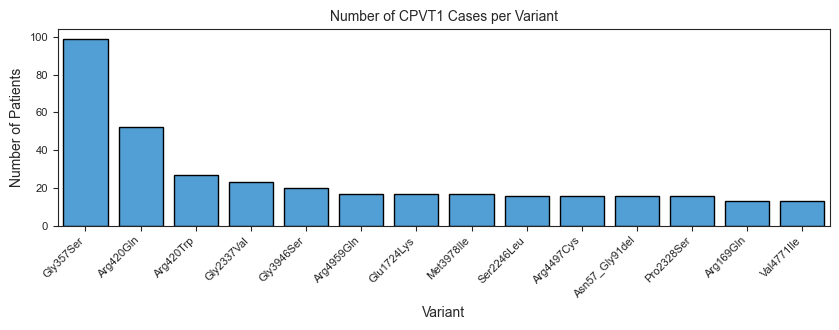

In [165]:
FIG_2_SIZE = (8.5, 3.4)

plt.figure(figsize=FIG_2_SIZE)
sns.barplot(
    data=num_cases_per_mutation,
    x="Variant",
    y="Number of Patients",
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
)
# plt.title("Number of CPVT1 Cases per Variant")
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels

set_figure_size(
    "Variant",
    "Number of Patients",
    "Number of CPVT1 Cases per Variant",
    x_tick_rotation=45,
    x_tick_ha="right",
)

save_current_plot("num_cases_per_variant")

plt.show()  # Display the plot

In [166]:
## Number of Variants per Exon (Missense variants only since there are fs mutations that basically span the entire gene)
variants_view = pd.read_sql(
    """
    SELECT LOWER(v.exons) AS exon, COUNT(DISTINCT v.variant_id) AS num_variants
    FROM variant_view_mv v
    JOIN individual_variant iv
    ON v.variant_id = iv.variant_id
    WHERE provenance @> jsonb_build_array(jsonb_build_object('dataset_id', 2))
    AND individual_id IN (
        SELECT cpvt.individual_id
        FROM cpvt_patients_v cpvt
    )
    AND LOWER(v.exons) + 1 = UPPER(v.exons)
    AND v.c_edit_type = 'substitution'
    GROUP BY LOWER(v.exons)
    ORDER BY num_variants DESC
    """,
    engine,
)

variants_view.head()

,exon,num_variants
0,90,45
1,47,12
2,8,10
3,14,9
4,94,8


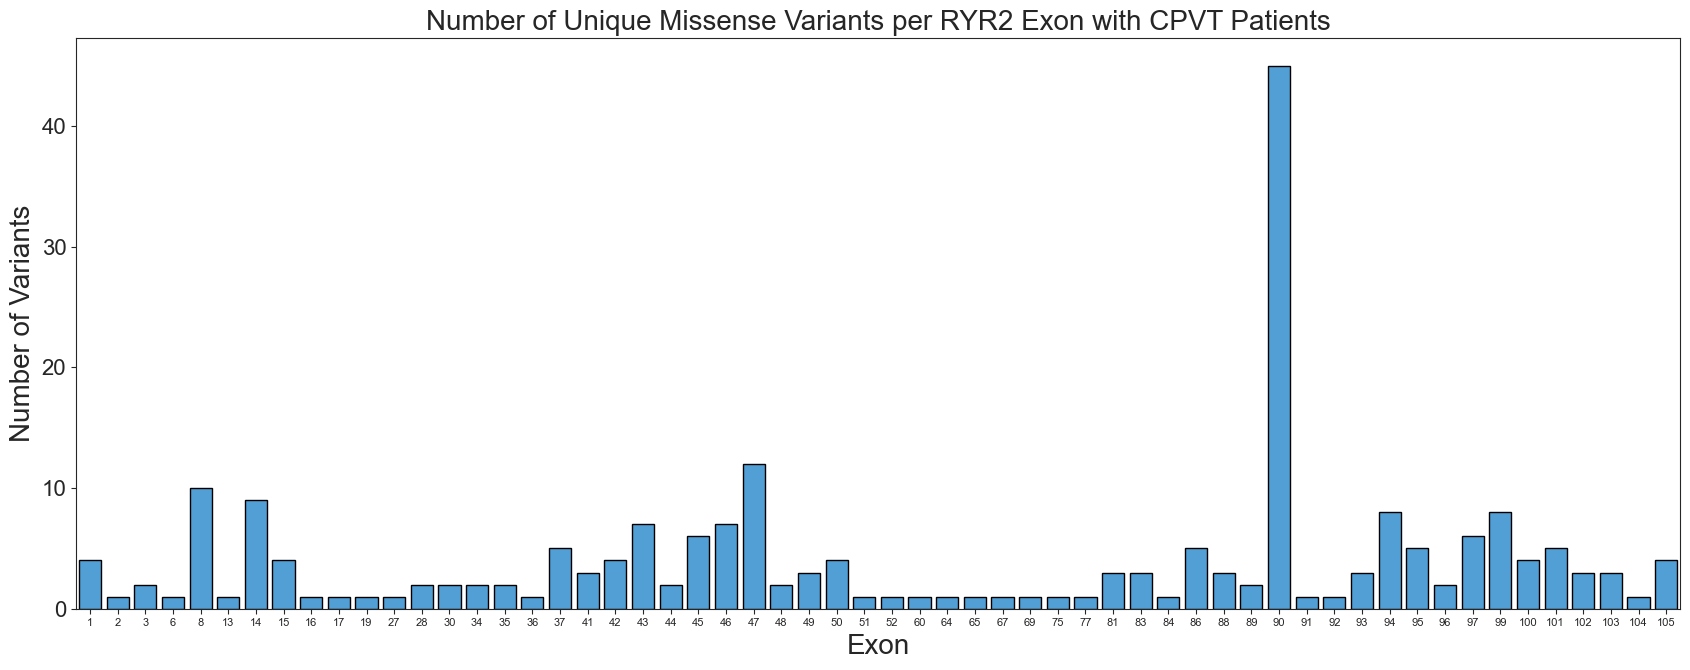

In [167]:
plt.figure(figsize=(FIG_2_SIZE[0] * 2, FIG_2_SIZE[1] * 2))  # Double the width and height

# y exons with more than 0 variants
plt_vars = variants_view[variants_view["num_variants"] > 0]

sns.barplot(
    data=variants_view,
    x="exon",
    y="num_variants",
    # palette="pastel",
    # hue='hue',
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
    order=plt_vars["exon"].sort_values(),
)
# plt.title(
#     "Number of Unique Missense Variants per Exon (RYR2) with CPVT1 Patients")
# 
# plt.xlabel("Exon")
# plt.ylabel("Number of Variants")
# 
# plt.xticks(rotation=90, fontsize=8)  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels
# 
# for fmt in ["png", "pdf", "svg"]:
#     plt.savefig(
#         os.path.join(figures_dir, f"num_variants_per_exon.{fmt}"), format=fmt,
#         dpi=300
#     )

set_figure_size(
    "Exon",
    "Number of Variants",
    "Number of Unique Missense Variants per RYR2 Exon with CPVT Patients",
    # double the font size
    x_label_fontsize=20,
    y_label_fontsize=20,
    title_fontsize=20,
    y_tick_fontsize=16,
)

save_current_plot("num_variants_per_exon")

plt.show()

# EDA for Age of Onset vs Exon for individuals

In [121]:
sns.choose_colorbrewer_palette("qualitative")

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

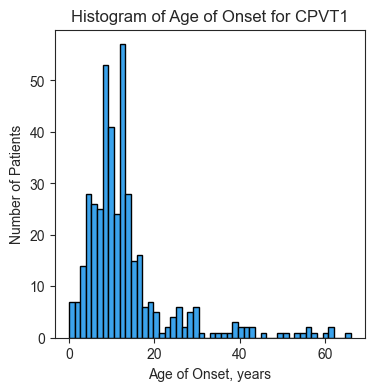

In [122]:
plt.figure(figsize=(4, 4))

# histogram of age of onset
df_all2["age_of_onset::CPVT1"].hist(bins=50,
                                    color=sns.color_palette("husl", 9)[6],
                                    edgecolor="black"

                                    )

plt.title("Histogram of Age of Onset for CPVT1")
plt.xlabel("Age of Onset, years")
plt.ylabel("Number of Patients")

# plt.axvline(median_aoo, color='tab:orange', linestyle='dashed', linewidth=1)
# plt.axvline(mean_aoo, color='tab:red', linestyle='dashed', linewidth=1)
#
# # Add text labels for median and mean
# plt.text(median_aoo, plt.ylim()[1] * 0.95, f'Median: {median_aoo:.2f}',
#          ha='right')
# plt.text(mean_aoo, plt.ylim()[1] * 0.95, f'Mean: {mean_aoo:.2f}',
#          ha='left')

plt.grid(False)

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"hist_age_of_onset.{fmt}"), format=fmt,
        dpi=300
    )

<Axes: xlabel='age_of_onset::CPVT1', ylabel='Density'>

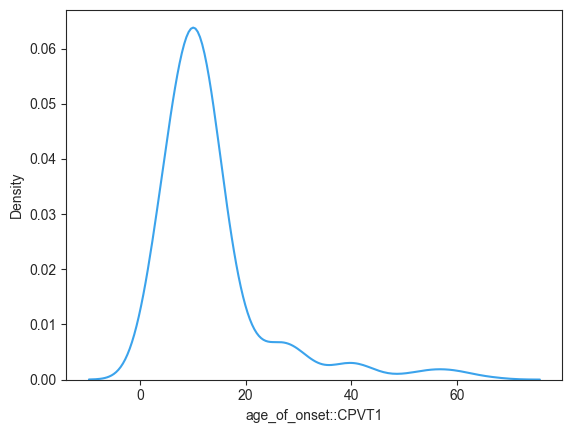

In [123]:
sns.kdeplot(df_all2["age_of_onset::CPVT1"],
            color=sns.color_palette("husl", 9)[6])

In [124]:
# print stats: mean, median, iqr
mean_aoo = df_all2["age_of_onset::CPVT1"].mean()
median_aoo = df_all2["age_of_onset::CPVT1"].median()
q1_aoo = df_all2["age_of_onset::CPVT1"].quantile(0.25)
q3_aoo = df_all2["age_of_onset::CPVT1"].quantile(0.75)

print(
    f"Mean: {mean_aoo:.2f}, Median: {median_aoo:.2f}, IQR: {q1_aoo:.2f}-{q3_aoo:.2f}"
)

Mean: 13.36, Median: 11.00, IQR: 7.00-14.00


In [125]:
# calculate skewness and kurtosis
skewness = df_all2["age_of_onset::CPVT1"].skew()
kurtosis = df_all2["age_of_onset::CPVT1"].kurtosis()

print(f"Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}")

Skewness: 2.41, Kurtosis: 6.76


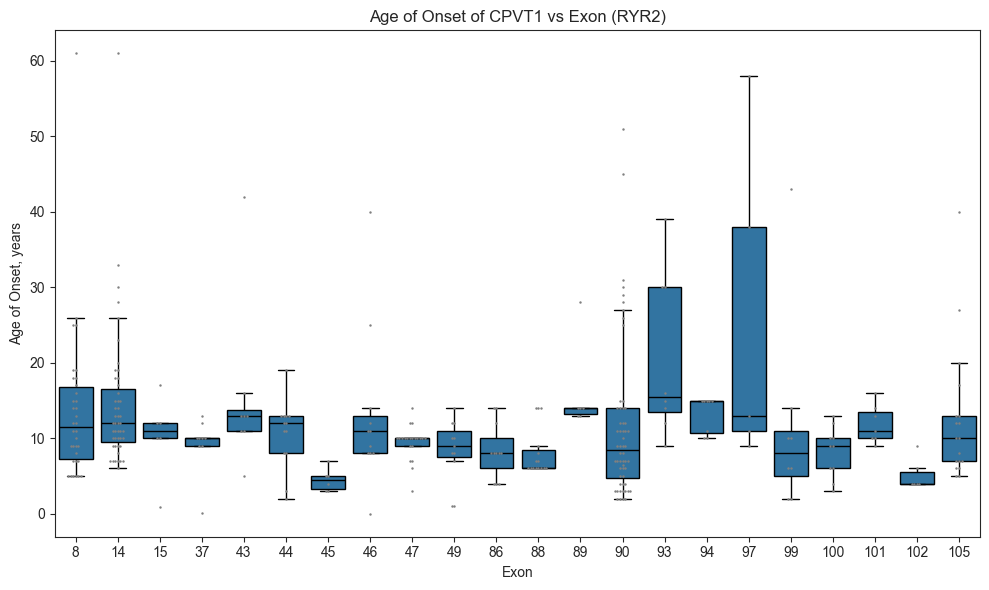

In [126]:
# violin plot of age of onset vs exon
# Create a subplot with custom dimensions

plt.figure(figsize=(10, 6))

# Due to the assumption that H has a chi square distribution,
# the number of samples in each group must not be too small. A typical rule is that each sample must have at least 5 measurements.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

MIN_NUM_INDIVIDUALS = 5

# fig, ax = plt.subplots(figsize=(15, 5))
filtered_data = df_all2.dropna(subset=["age_of_onset::CPVT1", "exon"])
# only show exons with more than 5 occurrences
filtered_data = filtered_data[
    filtered_data["exon"].isin(
        filtered_data.value_counts("exon")[
            filtered_data.value_counts("exon") >= MIN_NUM_INDIVIDUALS
            ].index.values
    )
]

ax = sns.boxplot(
    data=filtered_data,
    y="age_of_onset::CPVT1",
    x="exon",
    linewidth=1,
    width=0.8,
    # palette="Set1",
    # hue="exon",
    linecolor="black",
    # color=sns.color_palette("husl", 9)[6],
    showfliers=False,
)

# for violin, alpha in zip(ax.collections[::2], [0.8, 0.6, 0.4, 0.2]):
#     violin.set_alpha(alpha)

# Adjust the inner color alpha of the boxes
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))  # Set alpha to 0.6

# # Swarm plot on the same axes, with adjusted marker size for better fit
sns.swarmplot(
    data=filtered_data,
    x="exon",
    y="age_of_onset::CPVT1",
    color="gray",  # Make swarm dots black for contrast
    orient="v",
    size=1.75,
)

plt.title("Age of Onset of CPVT1 vs Exon (RYR2)")
plt.xlabel("Exon")
plt.ylabel("Age of Onset, years")

plt.grid(False)

plt.tight_layout()

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"age_of_onset_vs_exon_points.{fmt}"),
        format=fmt,
        dpi=300,
    )
plt.show()

Since these plots basically tell us that the data is not normally distributed, we need to do Kruskal-Wallis instead of ANOVA 
to test if the exon location has no effect on the age of onset.

In [127]:
filtered_data.head()

,age_of_onset::CPVT1,hgvs_string,p_hgvs_string,p_edit_type,domain,subdomain,exon
individual_id,,,,,,,
4,2.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
5,10.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
6,2.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
7,10.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
19,12.0,NM_001035.3:c.7175A>G,NP_001026.2:p.(Tyr2392Cys),Substitution,BSol,BSol1,47


In [128]:
import scipy.stats as stats

age_of_onset_by_exon = filtered_data.groupby("exon")

# Perform the Kruskal-Wallis test
stat, p = stats.kruskal(
    *[group["age_of_onset::CPVT1"] for _, group in age_of_onset_by_exon]
)

print(f"Kruskal-Wallis H-test: H={stat:.2f}, P={p:.2g}, dof={len(age_of_onset_by_exon) - 1}")

Kruskal-Wallis H-test: H=70.50, P=2.9e-07, dof=21


Apparently the exon location does have an effect on the age of onset. Post hoc Dunn test will need to be performed to determine which exons are significantly different.

In [190]:
CUSTOM_COLOR_PALLETTE = {
    "ntd": "7C93CB",
    "spry": "F8AE50",
    "jsol": "9F72B2",
    "bsol": "F1EA2E",
    "sclp": "61BC52",
    "csol": "0075BD",
    "taf": "CF5857",
    "tm": "A5A4A5",
    "ctd": "006C39"
}

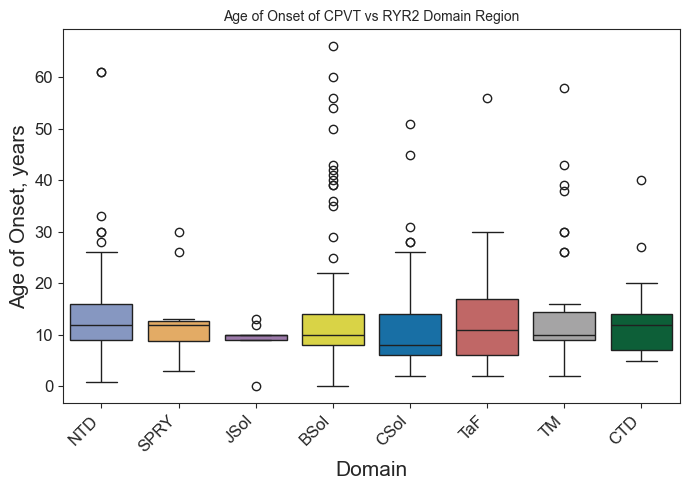

In [193]:
domain_cleaned = df_all2.dropna(subset=["age_of_onset::CPVT1", "domain"])[
    ["age_of_onset::CPVT1", "domain"]
]

domains_with_more_than_5 = (
    domain_cleaned["domain"]
    .value_counts()[
        domain_cleaned["domain"].value_counts() >= MIN_NUM_INDIVIDUALS]
    .index.values
)

domain_cleaned = domain_cleaned[
    domain_cleaned["domain"].isin(domains_with_more_than_5)]

domain_order = [
    v
    for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domains_with_more_than_5)
]

domain_color_mapping = {
    domain: "#" + CUSTOM_COLOR_PALLETTE[domain.lower()]
    for domain in domain_order
}

FIGURE_3_SIZE = (7, 5)

sns.set_style("ticks")
plt.figure(figsize=FIGURE_3_SIZE)

ax = sns.boxplot(
    data=domain_cleaned,
    y="age_of_onset::CPVT1",
    x="domain",
    linewidth=1,
    width=0.8,
    palette=domain_color_mapping,
    hue="domain",
    legend=False,
    order=domain_order,
    # showfliers=False,
)

plt.setp(ax.collections, alpha=.6)

# # Swarm plot on the same axes, with adjusted marker size for better fit
# sns.swarmplot(
#     data=domain_cleaned,
#     x="domain",
#     y="age_of_onset::CPVT1",
#     color="black",  # Make swarm dots black for contrast
#     orient="v",
#     size=2,
#     order=domain_order,
# )

# plt.title("Age of Onset of CPVT vs RYR2 Domain Region")
# plt.xlabel("Domain")
# plt.ylabel("Age of Onset, years")
# 
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.grid(False)
# plt.tight_layout()

set_figure_size(
    "Domain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Domain Region",
    x_tick_rotation=45,
    x_tick_ha="right",
    # set sizes 1.5x bigger for ticks and axes
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
)

save_current_plot("age_of_onset_vs_domain")

plt.show()

In [184]:
# Perform the Kruskal-Wallis test
stat, p = stats.kruskal(
    *[group["age_of_onset::CPVT1"] for _, group in
      domain_cleaned.groupby("domain")]
)
print(f"Kruskal-Wallis H-test: H={stat:.2f}, P={p:.2g}, dof={len(domain_cleaned['domain'].unique()) - 1}")

Kruskal-Wallis H-test: H=15.29, P=0.032, dof=7


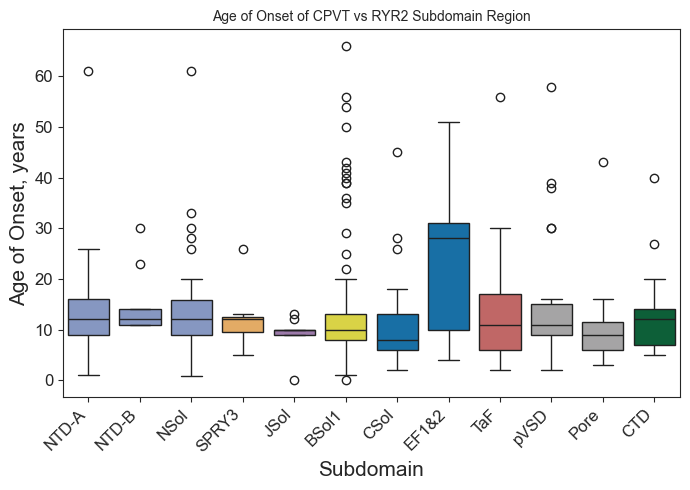

In [196]:
# By Subdomain

subdomain_cleaned = df_all2.dropna(subset=["age_of_onset::CPVT1", "subdomain", ])[
    ["age_of_onset::CPVT1", "subdomain", "domain"]
]

subdomains_with_more_than_5 = (
    subdomain_cleaned["subdomain"]
    .value_counts()[
        subdomain_cleaned["subdomain"].value_counts() >= MIN_NUM_INDIVIDUALS
        ]
    .index.values
)

subdomain_cleaned = subdomain_cleaned[
    subdomain_cleaned["subdomain"].isin(subdomains_with_more_than_5)
]

subdomain_order = [
    v
    for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(subdomains_with_more_than_5)
]

subdomain_color_mapping = {
    row["subdomain"]: "#" + CUSTOM_COLOR_PALLETTE[
        row["domain"].lower()
    ]
    for _, row in subdomain_cleaned.iterrows()
}

assert len(subdomain_order) == len(subdomains_with_more_than_5)

plt.figure(figsize=FIGURE_3_SIZE)

ax = sns.boxplot(
    data=subdomain_cleaned,
    y="age_of_onset::CPVT1",
    x="subdomain",
    width=0.8,
    palette=subdomain_color_mapping,
    hue="subdomain",
    legend=False,
    order=subdomain_order,
    # showfliers=False,
)

# plt.setp(ax.collections, alpha=.6)

# Basically same as domains
# sns.swarmplot(
#     data=subdomain_cleaned,
#     x="subdomain",
#     y="age_of_onset::CPVT1",
#     color="black",  # Make swarm dots black for contrast
#     orient="v",
#     size=2,
#     order=subdomain_order,
# )

# plt.title("Age of Onset of CPVT1 vs RyR2 Subdomain Region")
# plt.xlabel("Subdomain")
# plt.ylabel("Age of Onset, years")
# 
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.grid(False)
# 
# plt.tight_layout()

set_figure_size(
    "Subdomain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Subdomain Region",
    x_tick_rotation=45,
    x_tick_ha="right",
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
)

# for fmt in ["png", "pdf", "svg"]:
#     plt.savefig(
#         os.path.join(figures_dir, f"age_of_onset_vs_subdomain.{fmt}"),
#         format=fmt,
#         dpi=300,
#     )

save_current_plot("age_of_onset_vs_subdomain")

plt.show()

In [181]:
# Perform the Kruskal-Wallis test
stat, p = stats.kruskal(
    *[
        group["age_of_onset::CPVT1"]
        for _, group in subdomain_cleaned.groupby("subdomain")
    ]
)
print(f"Kruskal-Wallis H-test: H={stat:.2f}, P={p:.2g}, dof={len(subdomain_cleaned['subdomain'].unique()) - 1}")

Kruskal-Wallis H-test: H=27.93, P=0.0033, dof=11


## Dunn's Test

Since KW test showed that the exon location and domain/subdomain have an effect on the age of onset, we need to perform Dunn's test to determine which exons and domains/subdomains are significantly different. 

In [133]:
import scikit_posthocs as sp

In [134]:
# age of onset vs EXON
pvals_exons = sp.posthoc_dunn(
    filtered_data,
    val_col="age_of_onset::CPVT1",
    group_col="exon",
    p_adjust="bonferroni",
)
pvals_exons

,8,14,15,37,43,44,45,46,47,49,...,89,90,93,94,97,99,100,101,102,105
8,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.116725,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.324060,1.0
14,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.012985,1.0,1.000000,1.000000,...,1.000000,0.144614,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.042810,1.0
15,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
37,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
43,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.147181,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.337236,1.0
44,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.989795,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
45,0.116725,0.012985,1.0,1.0,0.147181,0.989795,1.000000,1.0,1.000000,1.000000,...,0.018904,1.000000,0.003620,0.039726,0.126278,1.0,1.000000,0.574686,1.000000,1.0
46,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
47,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.828353,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
49,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.633337,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0


In [135]:
# age of onset vs DOMAIN
pvals_domain = sp.posthoc_dunn(
    domain_cleaned,
    val_col="age_of_onset::CPVT1",
    group_col="domain",
    p_adjust="bonferroni",
)
pvals_domain

,BSol,CSol,CTD,JSol,NTD,SPRY,TM,TaF
BSol,1.000000,0.804261,1.0,1.0,1.000000,1.0,1.0,1.0
CSol,0.804261,1.000000,1.0,1.0,0.004941,1.0,1.0,1.0
CTD,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
JSol,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
NTD,1.000000,0.004941,1.0,1.0,1.000000,1.0,1.0,1.0
SPRY,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TM,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TaF,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0


In [136]:
# age of onset vs SUBDOMAIN
pvals_subdomain = sp.posthoc_dunn(
    subdomain_cleaned,
    val_col="age_of_onset::CPVT1",
    group_col="subdomain",
    p_adjust="bonferroni",
)
pvals_subdomain

,BSol1,CSol,CTD,EF1&2,JSol,NSol,NTD-A,NTD-B,Pore,SPRY3,TaF,pVSD
BSol1,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
CSol,1.0,1.000000,1.0,1.0,1.0,0.04209,0.146432,0.373648,1.000000,1.0,1.0,0.208349
CTD,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
EF1&2,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
JSol,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
NSol,1.0,0.042090,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.299520,1.0,1.0,1.000000
NTD-A,1.0,0.146432,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.647152,1.0,1.0,1.000000
NTD-B,1.0,0.373648,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.510236,1.0,1.0,1.000000
Pore,1.0,1.000000,1.0,1.0,1.0,0.29952,0.647152,0.510236,1.000000,1.0,1.0,0.657106
SPRY3,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000


## Significant Differences

In [137]:
# exon
significant_exons = pvals_exons[pvals_exons < 0.05].stack().index

exon_sig_set = set()
sig_exon_set = set()
for e1, e2 in significant_exons:
    sig_exons = (min(e1, e2), max(e1, e2))

    if sig_exons in exon_sig_set:
        continue

    exon_sig_set.add(sig_exons)
    sig_exon_set.add(e1)
    sig_exon_set.add(e2)
    print(f"{e1} vs {e2}, p={pvals_exons.loc[e1, e2]:.2g}")

14 vs 45, p=0.013
14 vs 102, p=0.043
45 vs 89, p=0.019
45 vs 93, p=0.0036
45 vs 94, p=0.04
89 vs 102, p=0.046
93 vs 102, p=0.01


In [138]:
# domain
significant_domains = pvals_domain[pvals_domain < 0.05].stack().index
for d1, d2 in significant_domains:
    print(f"{d1} vs {d2}, p={pvals_domain.loc[d1, d2]:.2g}")

CSol vs NTD, p=0.0049
NTD vs CSol, p=0.0049


In [139]:
# subdomain
significant_subdomains = pvals_subdomain[pvals_subdomain < 0.05].stack().index
for d1, d2 in significant_subdomains:
    print(f"{d1} vs {d2}, p={pvals_subdomain.loc[d1, d2]:.2g}")

CSol vs NSol, p=0.042
NSol vs CSol, p=0.042


For domains, it seems that the CSol and NTD domains are significantly different from each other.
We will take a look at the median age of onset and the IQRs for these two domains.

FOr the subdomains, the CSol and the NSol are significantly different from each other.
Again, we will take a look at the median age of onset and the IQRs for these two subdomains.

In [140]:
def get_median_and_mean(df_calc: pd.DataFrame):
    # NOTE: DUNN only tests if means are different, NOT medians!!!
    mean = df_calc["age_of_onset::CPVT1"].mean()
    median = df_calc["age_of_onset::CPVT1"].median()
    q1 = df_calc["age_of_onset::CPVT1"].quantile(0.25)
    q3 = df_calc["age_of_onset::CPVT1"].quantile(0.75)

    return mean, median, q1, q3


def print_median_and_iqr(df_calc: pd.DataFrame, name: str):
    mean, median, q1, q3 = get_median_and_mean(df_calc)

    print(
        f"{name}: mean={mean:.2f}, median={median:.2f}, IQR={q1:.2f}-{q3:.2f}, n={len(df_calc)}"
    )

In [141]:
# EXONS:
for exon in sig_exon_set:
    exon_df = filtered_data[filtered_data["exon"] == exon]

    print_median_and_iqr(exon_df, f"Exon {exon}")

Exon 102: mean=5.17, median=4.00, IQR=4.00-5.50, n=6
Exon 45: mean=4.50, median=4.50, IQR=3.25-5.00, n=6
Exon 14: mean=14.57, median=12.00, IQR=9.50-16.50, n=47
Exon 89: mean=16.00, median=14.00, IQR=13.25-14.00, n=6
Exon 93: mean=20.62, median=15.50, IQR=13.50-30.00, n=8
Exon 94: mean=13.25, median=15.00, IQR=10.75-15.00, n=8


In [142]:
# print for every exon
for exon in filtered_data["exon"].unique():
    exon_df = filtered_data[filtered_data["exon"] == exon]

    print_median_and_iqr(exon_df, f"Exon {exon}")

Exon 99: mean=11.62, median=8.00, IQR=5.00-11.00, n=8
Exon 47: mean=9.48, median=10.00, IQR=9.00-10.00, n=21
Exon 8: mean=13.71, median=11.50, IQR=7.25-16.75, n=34
Exon 100: mean=8.20, median=9.00, IQR=6.00-10.00, n=10
Exon 101: mean=11.86, median=11.00, IQR=10.00-13.50, n=7
Exon 49: mean=8.36, median=9.00, IQR=7.50-11.00, n=11
Exon 46: mean=13.27, median=11.00, IQR=8.00-13.00, n=11
Exon 45: mean=4.50, median=4.50, IQR=3.25-5.00, n=6
Exon 43: mean=15.50, median=13.00, IQR=11.00-13.75, n=8
Exon 14: mean=14.57, median=12.00, IQR=9.50-16.50, n=47
Exon 90: mean=11.58, median=8.50, IQR=4.75-14.00, n=56
Exon 44: mean=10.62, median=12.00, IQR=8.00-13.00, n=13
Exon 105: mean=12.50, median=10.00, IQR=7.00-13.00, n=18
Exon 93: mean=20.62, median=15.50, IQR=13.50-30.00, n=8
Exon 15: mean=10.32, median=11.00, IQR=10.00-12.00, n=6
Exon 86: mean=8.36, median=8.00, IQR=6.00-10.00, n=11
Exon 89: mean=16.00, median=14.00, IQR=13.25-14.00, n=6
Exon 102: mean=5.17, median=4.00, IQR=4.00-5.50, n=6
Exon 97

In [143]:
csol_domain = domain_cleaned[domain_cleaned["domain"] == "CSol"]

print_median_and_iqr(csol_domain, "CSol")

CSol: mean=10.79, median=8.00, IQR=6.00-14.00, n=75


In [144]:
ntd_domain = domain_cleaned[domain_cleaned["domain"] == "NTD"]

print_median_and_iqr(ntd_domain, "NTD")

NTD: mean=13.88, median=12.00, IQR=9.00-16.00, n=105


In [145]:
# SUBDOMAIN
csol_subdomain = subdomain_cleaned[subdomain_cleaned["subdomain"] == "CSol"]

print_median_and_iqr(csol_subdomain, "CSol (Subdomain)")

CSol (Subdomain): mean=9.79, median=8.00, IQR=6.00-13.00, n=70


In [146]:
nsol_subdomain = subdomain_cleaned[subdomain_cleaned["subdomain"] == "NSol"]

print_median_and_iqr(nsol_subdomain, "NSol (Subdomain)")

NSol (Subdomain): mean=14.00, median=12.00, IQR=9.00-15.75, n=50


# Age of onset vs Year Published

Although not in the original manuscript, many people have commented on the possibility that the age of onset may be affected by the year of the paper being written as we have better diagonis vs the past. 

Therefore, we would expect to see some sort of negative correlation between the year of the paper and the age of onset.

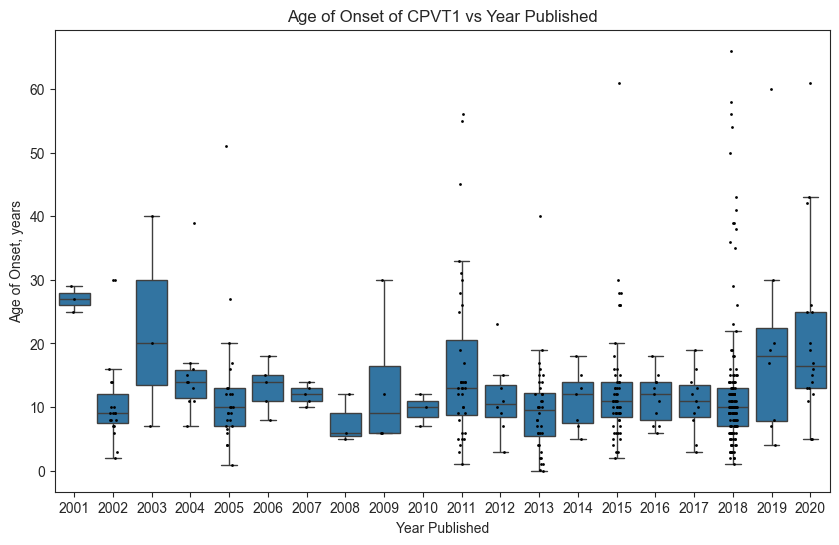

In [147]:
# plot age of onset vs year
plt.figure(figsize=(10, 6))

df_aoo_vs_year = df_all.dropna(
    subset=["year",
            "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1"]
).rename(
    columns={
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1": "age_of_onset::CPVT1"
    }
)[[
    "year",
    "age_of_onset::CPVT1"
]]

df_aoo_vs_year["year"] = df_aoo_vs_year["year"].astype(int)

sns.stripplot(data=df_aoo_vs_year, x="year", y="age_of_onset::CPVT1",
              color="black", size=2)

sns.boxplot(
    data=df_aoo_vs_year,
    x="year",
    y="age_of_onset::CPVT1",
    linewidth=1,
    showfliers=False,
)

plt.title("Age of Onset of CPVT1 vs Year Published")
plt.xlabel("Year Published")
plt.ylabel("Age of Onset, years")

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"age_of_onset_vs_year.{fmt}"),
        format=fmt,
        dpi=300,
    )

plt.show()

In [148]:
# calculate the correlation coefficient
df_aoo_vs_year.corr()

,year,age_of_onset::CPVT1
year,1.000000,0.023093
age_of_onset::CPVT1,0.023093,1.000000


Basically there is no correlation between the year of the paper and the age of onset. (pearson's r = 0.023) - basically like 0, and somehow its slightly positive so somehow we are catching older patients in the newer papers.

# Scratch

In [149]:
domains_df["domains"].dropna().str.strip().values

array(['NTD', 'SPRY', 'JSol', 'BSol', 'SCLP', 'CSol', 'TaF', 'TM', 'CTD'],
      dtype=object)

In [150]:
df_all2.dropna(subset=["age_of_onset::CPVT1", "domain"])[
    ["age_of_onset::CPVT1", "domain"]
].value_counts("domain")

domain
NTD     105
BSol     92
CSol     75
TM       63
CTD      26
TaF      24
SPRY     10
JSol      9
SCLP      2
Name: count, dtype: int64

In [151]:
domain_cleaned.groupby("domain").aggregate(["median", "std", "count"])

age_of_onset::CPVT1                 
                    median        std count
domain                                     
BSol                  10.0  14.016167    92
CSol                   8.0   8.569309    75
CTD                   12.0   7.713724    26
JSol                  10.0   3.660137     9
NTD                   12.0   8.939270   105
SPRY                  12.0   8.521867    10
TM                    10.0  10.259086    63
TaF                   11.0  12.523601    24

In [152]:
subdomain_order

['NTD-A',
 'NTD-B',
 'NSol',
 'SPRY3',
 'JSol',
 'BSol1',
 'CSol',
 'EF1&2',
 'TaF',
 'pVSD',
 'Pore',
 'CTD']

In [153]:
subdomains_with_more_than_5

array(['BSol1', 'CSol', 'NSol', 'NTD-A', 'pVSD', 'Pore', 'TaF', 'CTD',
       'NTD-B', 'JSol', 'SPRY3', 'EF1&2'], dtype=object)